In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor

In [436]:
# Load dataset
file_path = '/Users/mireia/Downloads/Apple 2009-2024.csv'
def load_data(filepath):
    df = pd.read_csv(file_path)
    return df

# Inspect the first few rows and dataset info
df.head(), df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          16 non-null     int64  
 1   EBITDA (millions)             16 non-null     float64
 2   Revenue (millions)            16 non-null     float64
 3   Gross Profit (millions)       16 non-null     float64
 4   Op Income (millions)          16 non-null     float64
 5   Net Income (millions)         16 non-null     float64
 6   EPS                           16 non-null     float64
 7   Shares Outstanding            16 non-null     float64
 8   Year Close Price              16 non-null     float64
 9   Total Assets (millions)       16 non-null     float64
 10  Cash on Hand (millions)       16 non-null     float64
 11  Long Term Debt (millions)     16 non-null     float64
 12  Total Liabilities (millions)  16 non-null     float64
 13  Gross M

(   year  EBITDA (millions)  Revenue (millions)  Gross Profit (millions)  \
 0  2024           134661.0            391035.0                 180683.0   
 1  2023           125820.0            383285.0                 169148.0   
 2  2022           130541.0            394328.0                 170782.0   
 3  2021           120233.0            365817.0                 152836.0   
 4  2020            77344.0            274515.0                 104956.0   
 
    Op Income (millions)  Net Income (millions)   EPS  Shares Outstanding  \
 0              123216.0                93736.0  6.08             15408.0   
 1              114301.0                96995.0  6.13             15813.0   
 2              119437.0                99803.0  6.11             16326.0   
 3              108949.0                94680.0  5.61             16865.0   
 4               66288.0                57411.0  3.28             17528.0   
 
    Year Close Price  Total Assets (millions)  Cash on Hand (millions)  \
 0  

In [438]:
df = clean_money_columns(df)
print(df.dtypes)
def clean_money_columns(df):
    money_cols = [
        'EBITDA (millions)', 'Revenue (millions)', 'Gross Profit (millions)',
        'Op Income (millions)', 'Net Income (millions)', 'Shares Outstanding',
        'Total Assets (millions)', 'Cash on Hand (millions)',
        'Long Term Debt (millions)', 'Total Liabilities (millions)',
        'Employees', 'EPS'
    ]

    for col in money_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r'[\$,]', '', regex=True)  # Remove $ and ,
            .str.replace(r'[^\d.\-]', '', regex=True)  # Remove anything unexpected
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float64

    return df


year                              int64
EBITDA (millions)               float64
Revenue (millions)              float64
Gross Profit (millions)         float64
Op Income (millions)            float64
Net Income (millions)           float64
EPS                             float64
Shares Outstanding              float64
Year Close Price                float64
Total Assets (millions)         float64
Cash on Hand (millions)         float64
Long Term Debt (millions)       float64
Total Liabilities (millions)    float64
Gross Margin                    float64
PE ratio                        float64
Employees                         int64
Revenue_Change                  float64
EBITDA_Change                   float64
Gross_Profit_Change             float64
dtype: object


In [439]:
def clean_money_and_percentage_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Remove $ and commas
            df[col] = df[col].str.replace('$', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            # Remove %
            df[col] = df[col].str.replace('%', '', regex=False)
            # Try to convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


In [440]:
def preprocess_data(df):
    df = df.copy()
    df.dropna(inplace=True)
    df = df[df['Year Close Price'] > 0]  # Filter if needed
    return df

In [441]:
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees,Revenue_Change,EBITDA_Change,Gross_Profit_Change
0,2024,134661.0,391035.0,180683.0,123216.0,93736.0,6.08,15408.0,243.0400,364980.0,65171.0,85750.0,308030.0,46.21,39.97,164000,NaN,NaN,NaN
1,2023,125820.0,383285.0,169148.0,114301.0,96995.0,6.13,15813.0,191.5919,352583.0,61555.0,95281.0,290437.0,45.03,29.84,161000,-0.019819,-0.065654,-0.063841
2,2022,130541.0,394328.0,170782.0,119437.0,99803.0,6.11,16326.0,128.5816,352755.0,48304.0,98959.0,302083.0,43.06,21.83,164000,0.028811,0.037522,0.009660
3,2021,120233.0,365817.0,152836.0,108949.0,94680.0,5.61,16865.0,174.7132,351002.0,62639.0,109106.0,287912.0,43.02,28.93,154000,-0.072303,-0.078964,-0.105081
4,2020,77344.0,274515.0,104956.0,66288.0,57411.0,3.28,17528.0,129.7556,323888.0,90943.0,98667.0,258549.0,38.78,35.14,147000,-0.249584,-0.356716,-0.313277


In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          16 non-null     int64  
 1   EBITDA (millions)             16 non-null     float64
 2   Revenue (millions)            16 non-null     float64
 3   Gross Profit (millions)       16 non-null     float64
 4   Op Income (millions)          16 non-null     float64
 5   Net Income (millions)         16 non-null     float64
 6   EPS                           16 non-null     float64
 7   Shares Outstanding            16 non-null     float64
 8   Year Close Price              16 non-null     float64
 9   Total Assets (millions)       16 non-null     float64
 10  Cash on Hand (millions)       16 non-null     float64
 11  Long Term Debt (millions)     16 non-null     float64
 12  Total Liabilities (millions)  16 non-null     float64
 13  Gross M

In [443]:
def plot_eda(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation")
    plt.show()

    # Scatter vs target
    features = [col for col in df.columns if col not in ['year', 'Year Close Price']]
    for col in features:
        sns.scatterplot(x=df[col], y=df['Year Close Price'])
        plt.title(f"{col} vs Close Price")
        plt.xlabel(col)
        plt.ylabel("Close Price")
        plt.show()


In [444]:
def split_data(df):
    X = df.drop(columns=['Year Close Price', 'year'])
    y = df['Year Close Price']
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [445]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}\n")
    return preds

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
    }
    
    for name, model in models.items():
        print(f"--- {name} ---")
        model.fit(X_train, y_train)
        preds = evaluate_model(model, X_test, y_test)


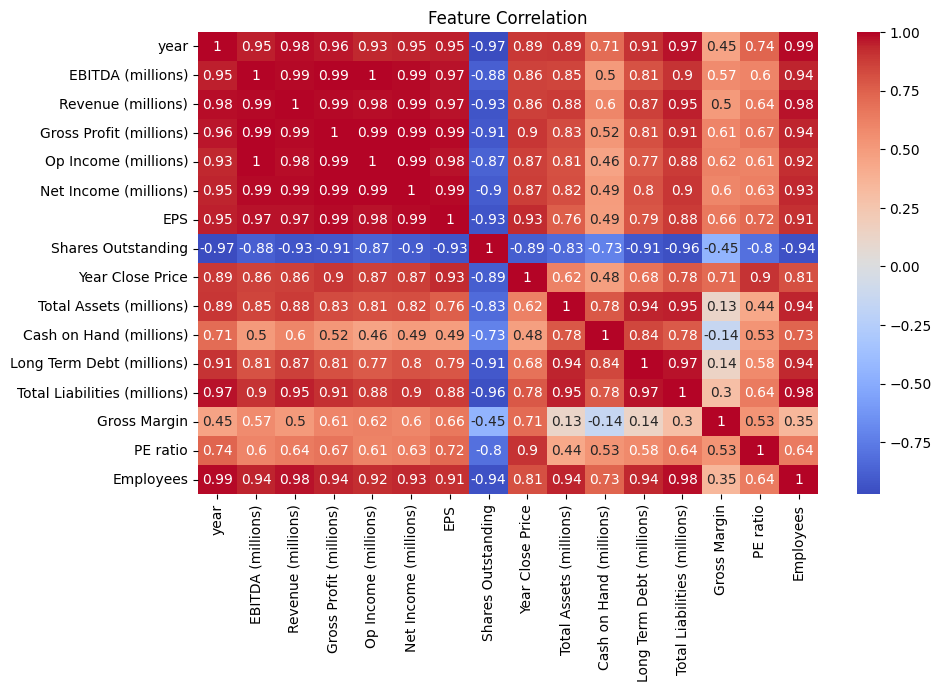

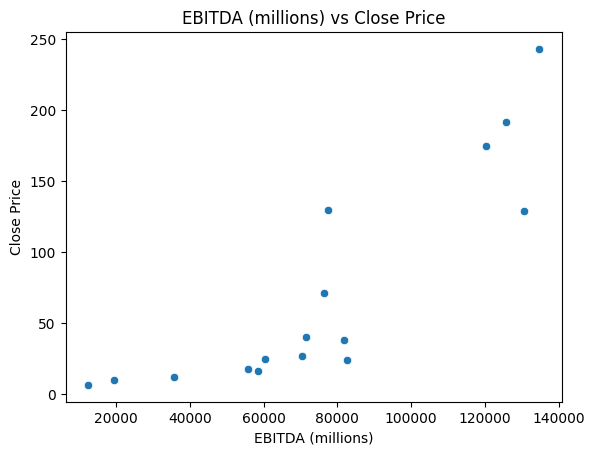

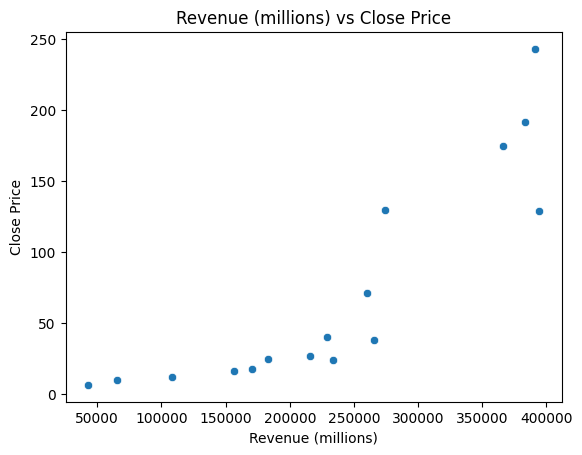

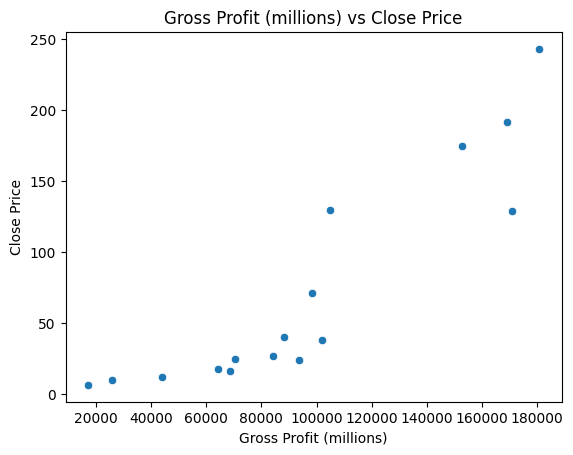

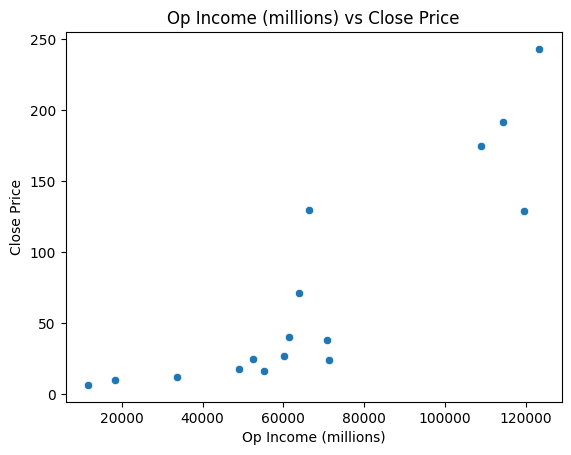

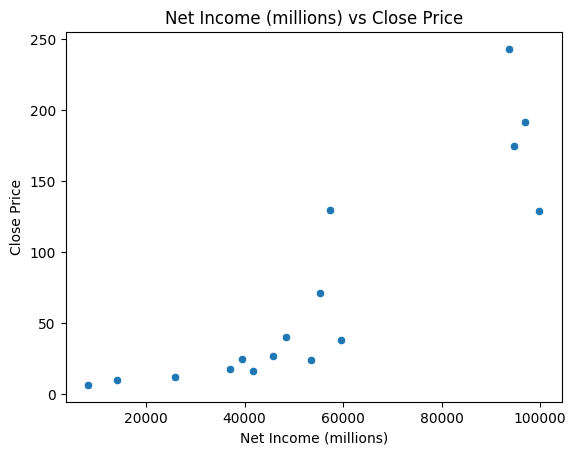

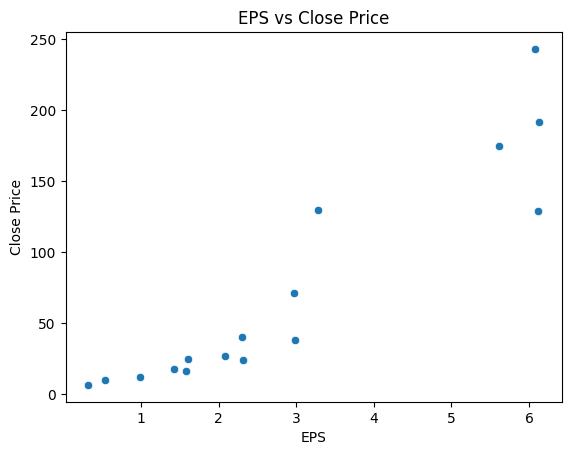

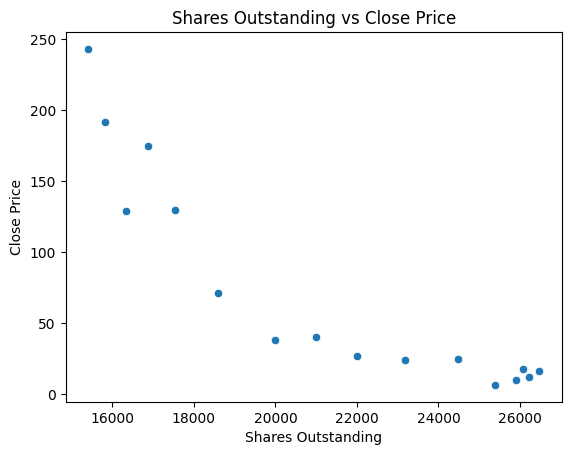

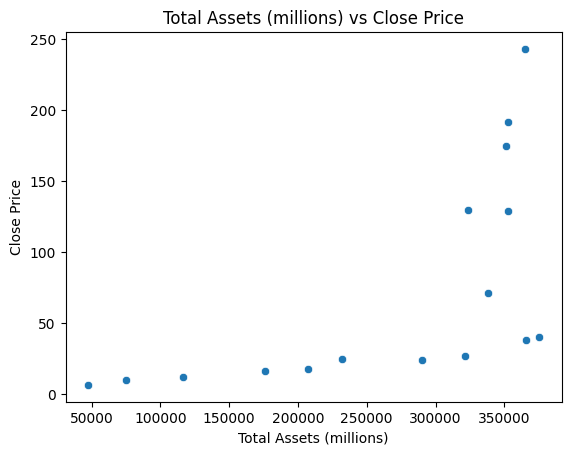

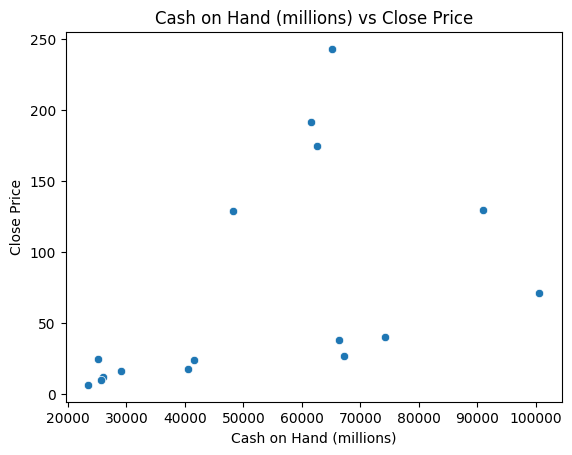

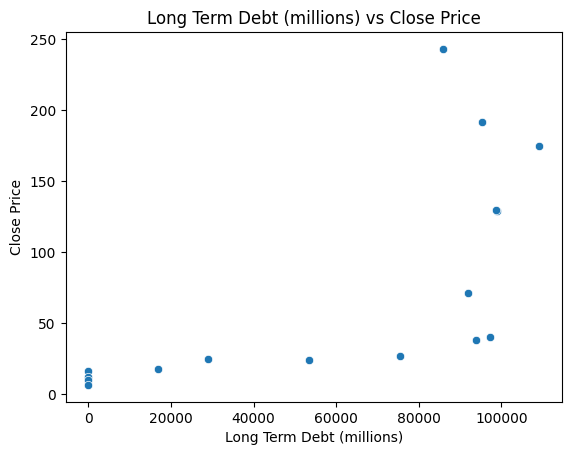

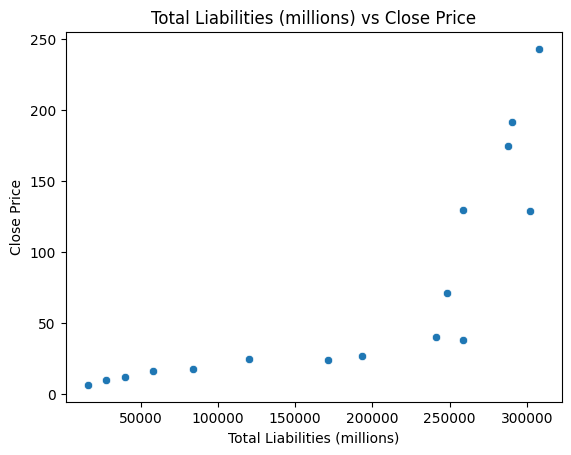

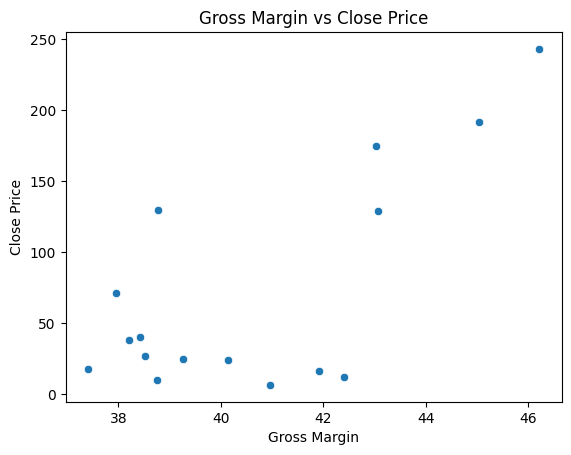

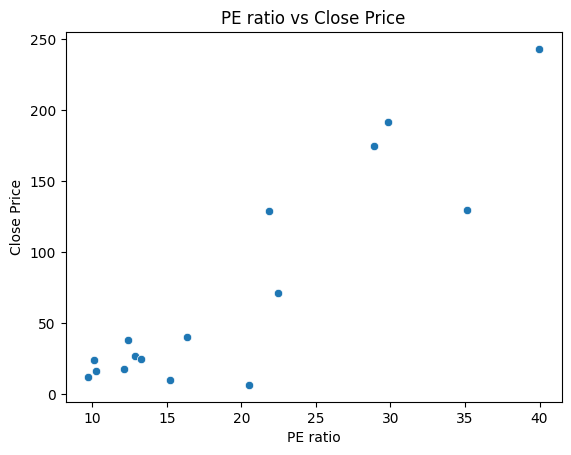

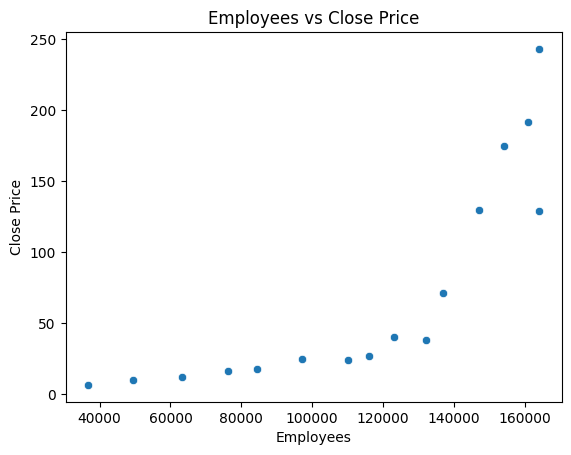

--- Linear Regression ---
MAE: 109.17
RMSE: 128.45
R2 Score: -0.91

--- Random Forest ---
MAE: 44.59
RMSE: 63.09
R2 Score: 0.54

--- XGBoost ---
MAE: 53.49
RMSE: 67.41
R2 Score: 0.47



In [446]:
def main(df):  # take cleaned df as input
    plot_eda(df)

    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate_models(X_train, X_test, y_train, y_test)

if __name__ == '__main__':
    df = pd.read_csv("/Users/mireia/Downloads/Apple 2009-2024.csv")
    df = clean_money_and_percentage_columns(df)
    df = preprocess_data(df)  # If needed

    main(df)

In [447]:
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} MAE: {mae:.2f}")
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} MAPE: {mape:.2f}%")
    return mae, rmse, mape

In [448]:
# Clean up columns with dollar signs, commas, and percentage signs
def clean_column(col):
    return col.replace({'\$': '', ',': ''}, regex=True).astype(float)

# List of columns to clean
columns_to_clean = ['EBITDA (millions)', 'Revenue (millions)', 'Gross Profit (millions)', 
                    'Op Income (millions)', 'Net Income (millions)', 'Shares Outstanding', 
                    'Year Close Price', 'Total Assets (millions)', 'Cash on Hand (millions)', 
                    'Long Term Debt (millions)', 'Total Liabilities (millions)']

# Apply cleaning function to the selected columns
for col in columns_to_clean:
    df[col] = clean_column(df[col])

# Clean up percentage columns (if any), such as 'Gross Margin'
df['Gross Margin'] = df['Gross Margin'].replace({'%': ''}, regex=True).astype(float)

# Inspect the cleaned dataset
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees
0,2024,134661.0,391035.0,180683.0,123216.0,93736.0,6.08,15408.0,243.0400,364980.0,65171.0,85750.0,308030.0,46.21,39.97,164000
1,2023,125820.0,383285.0,169148.0,114301.0,96995.0,6.13,15813.0,191.5919,352583.0,61555.0,95281.0,290437.0,45.03,29.84,161000
2,2022,130541.0,394328.0,170782.0,119437.0,99803.0,6.11,16326.0,128.5816,352755.0,48304.0,98959.0,302083.0,43.06,21.83,164000
3,2021,120233.0,365817.0,152836.0,108949.0,94680.0,5.61,16865.0,174.7132,351002.0,62639.0,109106.0,287912.0,43.02,28.93,154000
4,2020,77344.0,274515.0,104956.0,66288.0,57411.0,3.28,17528.0,129.7556,323888.0,90943.0,98667.0,258549.0,38.78,35.14,147000


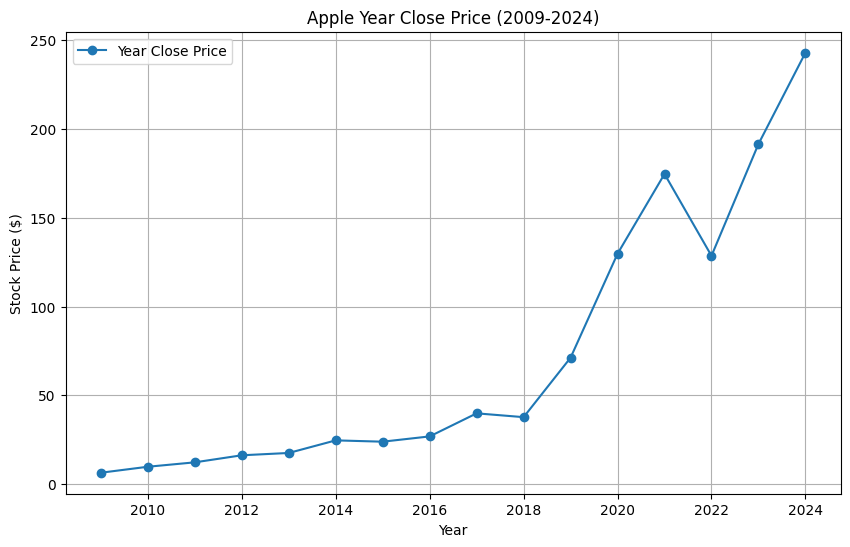

In [449]:
import matplotlib.pyplot as plt

# Plot Year Close Price
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['Year Close Price'], label='Year Close Price', marker='o')
plt.title('Apple Year Close Price (2009-2024)')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [450]:
# Calculate percentage changes for various financial metrics
df['Revenue_Change'] = df['Revenue (millions)'].pct_change()
df['EBITDA_Change'] = df['EBITDA (millions)'].pct_change()
df['Gross_Profit_Change'] = df['Gross Profit (millions)'].pct_change()

# Check the new columns
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees,Revenue_Change,EBITDA_Change,Gross_Profit_Change
0,2024,134661.0,391035.0,180683.0,123216.0,93736.0,6.08,15408.0,243.0400,364980.0,65171.0,85750.0,308030.0,46.21,39.97,164000,NaN,NaN,NaN
1,2023,125820.0,383285.0,169148.0,114301.0,96995.0,6.13,15813.0,191.5919,352583.0,61555.0,95281.0,290437.0,45.03,29.84,161000,-0.019819,-0.065654,-0.063841
2,2022,130541.0,394328.0,170782.0,119437.0,99803.0,6.11,16326.0,128.5816,352755.0,48304.0,98959.0,302083.0,43.06,21.83,164000,0.028811,0.037522,0.009660
3,2021,120233.0,365817.0,152836.0,108949.0,94680.0,5.61,16865.0,174.7132,351002.0,62639.0,109106.0,287912.0,43.02,28.93,154000,-0.072303,-0.078964,-0.105081
4,2020,77344.0,274515.0,104956.0,66288.0,57411.0,3.28,17528.0,129.7556,323888.0,90943.0,98667.0,258549.0,38.78,35.14,147000,-0.249584,-0.356716,-0.313277


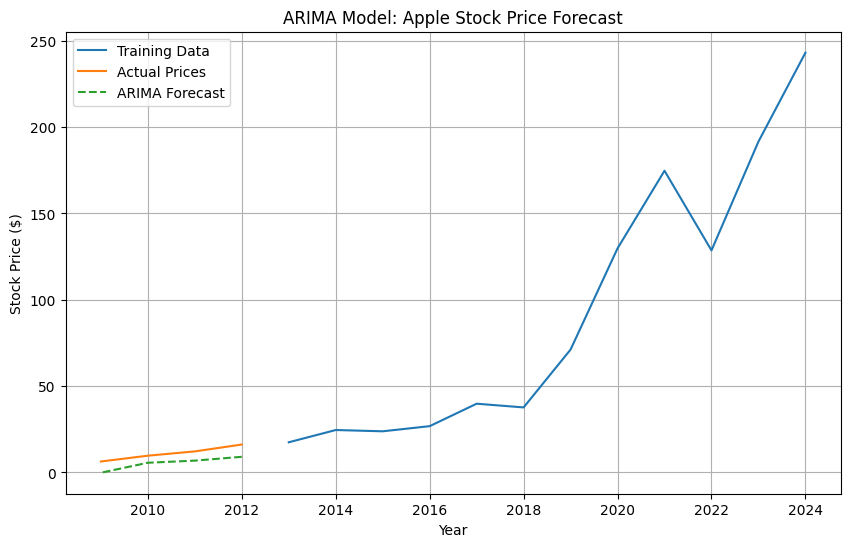

In [432]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit ARIMA model (p, d, q) values are initial guesses, can be optimized later
model_arima = ARIMA(train['Year Close Price'], order=(5, 1, 0))  # ARIMA(p,d,q)
model_arima_fit = model_arima.fit()

# Forecast for the test set
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(train['year'], train['Year Close Price'], label='Training Data')
plt.plot(test['year'], test['Year Close Price'], label='Actual Prices')
plt.plot(test['year'], forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Model: Apple Stock Price Forecast')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.grid(True)
plt.show()


In [451]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, RMSE
mae = mean_absolute_error(test['Year Close Price'], forecast_arima)
rmse = np.sqrt(mean_squared_error(test['Year Close Price'], forecast_arima))

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test['Year Close Price'] - forecast_arima) / test['Year Close Price'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 5.76
RMSE: 5.87
MAPE: 58.05%
